In [91]:
# import dependencies
import numpy as np
import pandas as pd
from lxml import etree
from PIL import Image
from copy import copy
from scipy.interpolate import interp1d
# plotting packages
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# custom package
from radstats import diagram,models,bayes,environment

In [92]:
### plotly template
template = go.layout.Template()
template.layout = {
    'paper_bgcolor':'rgba(0,0,0,0)',
    'plot_bgcolor':'rgba(0,0,0,0)',
    'xaxis':{'tickformat':'none','hoverformat':'.3e','showline':True,'mirror':True,'title':{'standoff':5}},
    'yaxis':{'tickformat':'.0e','hoverformat':'.3e','showline':True,'mirror':True},
    'width':400,
    'height':300,
    'font':{'family':'Times New Roman'}
}
template.data.scatter = [go.Scatter(
    marker = {'symbol':'circle-open','size':5},
    line = {'width':1}
)]
pio.templates.default = template
pio.renderers.default = 'notebook'

def autocrop(image_file):
    image = Image.open(image_file)
    image.crop(image.getbbox()).save(image_file)
    return image

In [93]:
project = 'projects/case2' # declare the project directory

subset = None #['SRAM','MCU','REG','WDT','Payload']

orbits = 30
creme_prefix = 'gto'

generate_environment = False
run_analysis = False
run_sim = False
downsample = 1000

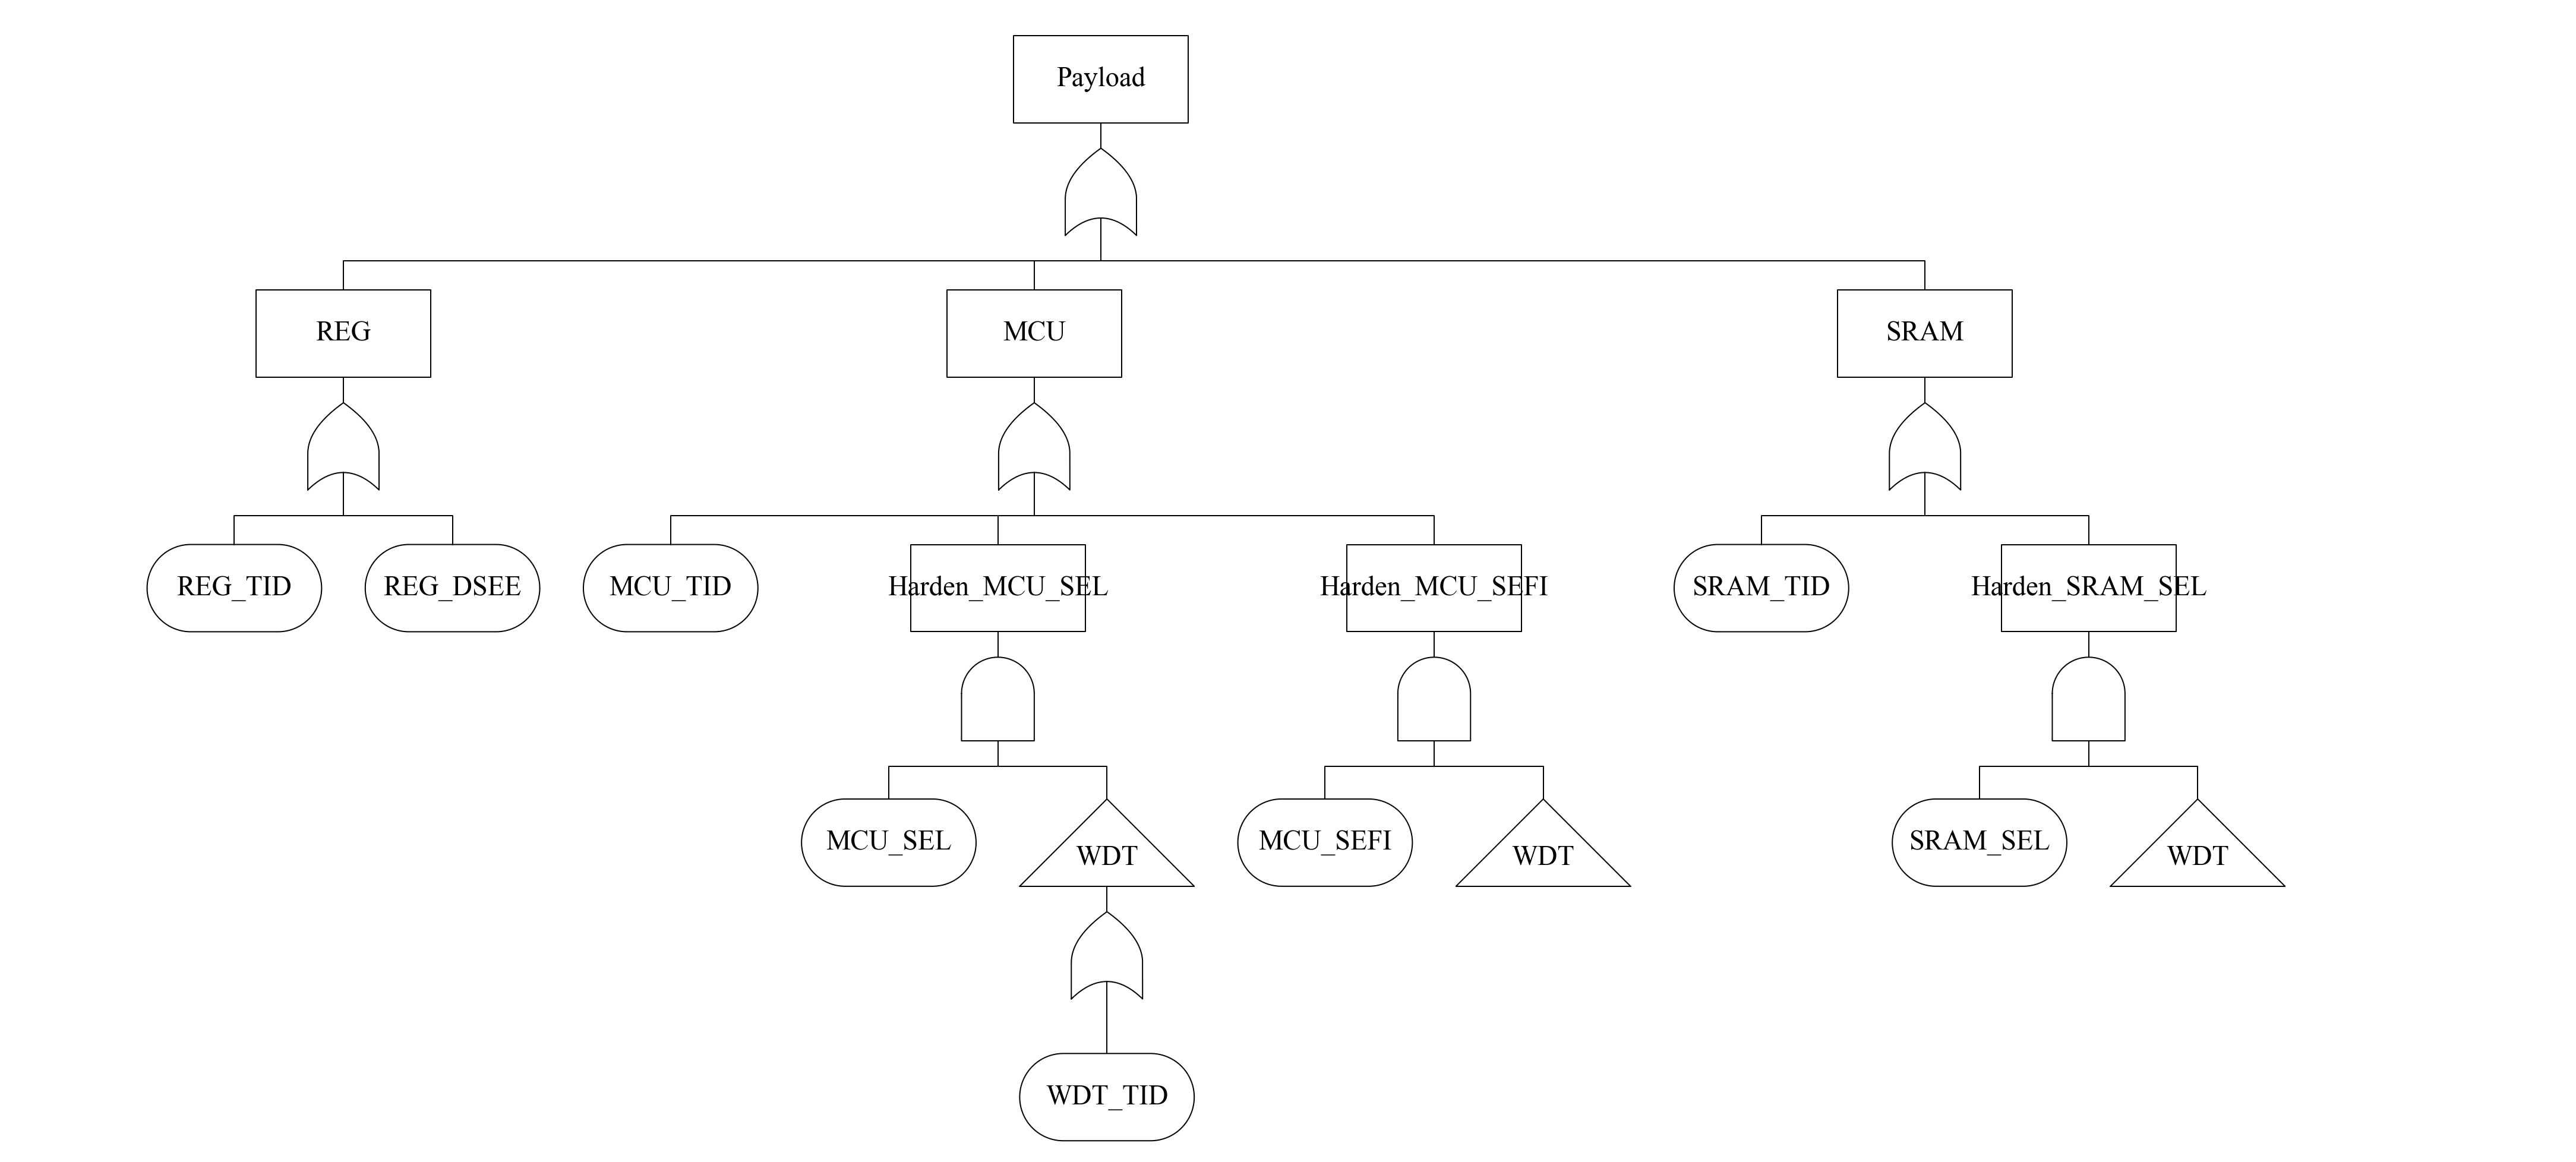

In [94]:
diagram.spacing = (3,3.5) # diagram element spacing (x,y)
diagram.shape = (2.4,1.2) # diagram element shapes (x,y)
diagram.fontsize = 24
system = etree.parse(f'{project}/system.xml') # read 'system.xml' from the project directory
diagram.newFT(system,file=f'{project}/figures/system.png') # show the fault tree and save the diagram
autocrop(f'{project}/figures/system.png')

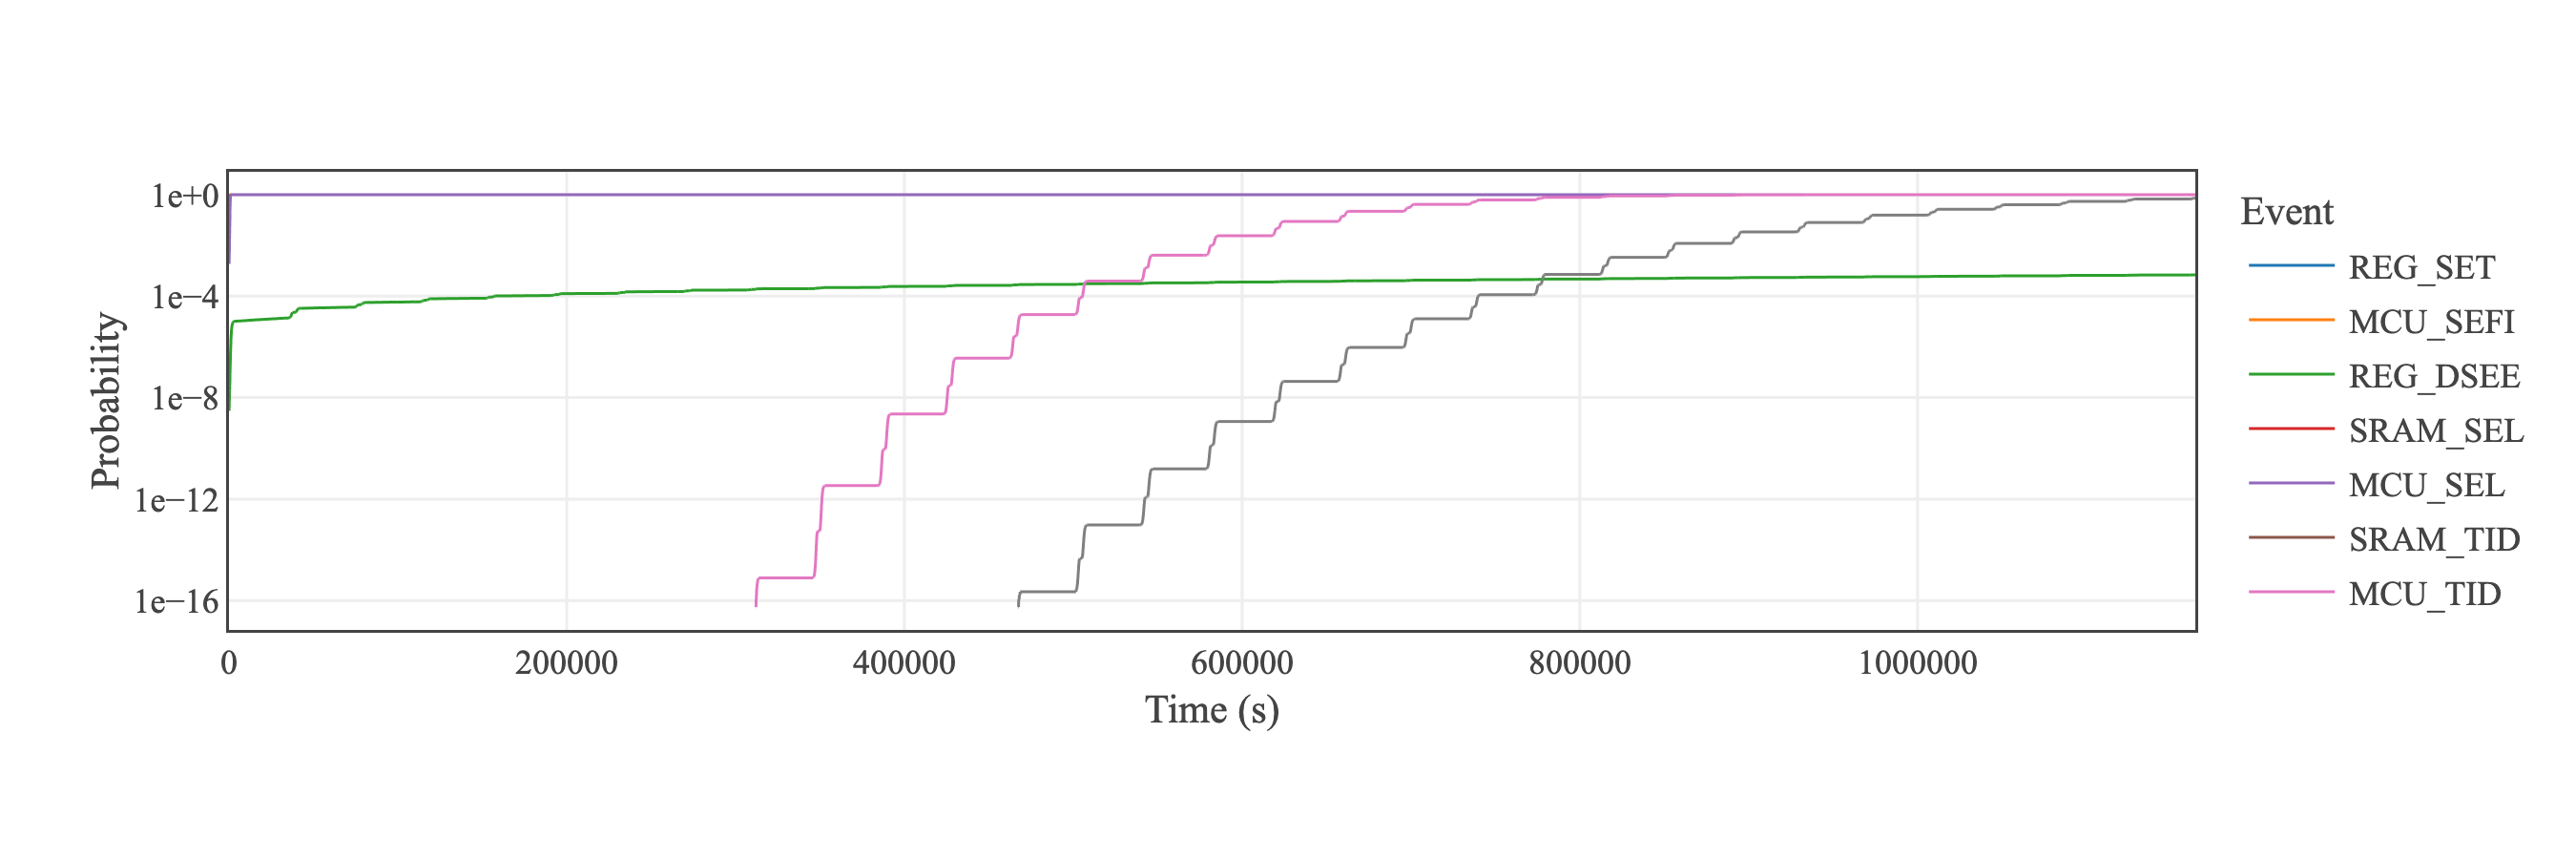

In [95]:
### read spenvis trajectory

if generate_environment:
    env = environment.read_spenvis(f'{project}/spenvis/spenvis_sao.txt')[1]['DF']
    env['L-shell'] = environment.read_spenvis(f'{project}/spenvis/spenvis_spp.txt')[1]['DF']['L (!8R!3!dE!n)']
    env.index = pd.to_timedelta(env['MJD (days)']-int(env['MJD (days)'][0]),unit='days')
    env.index = pd.Series(env.index,name='Time (s)').dt.seconds

    ### repeat orbits
    env.index = pd.Series(env.index).diff().bfill()
    env.loc[:,'Orbit'] = 0
    for o in range(1,orbits):
        orbit = env.loc[env['Orbit'] == 0]
        orbit.loc[:,'Orbit'] = o
        env = pd.concat([env,orbit])
    env.index = np.around(pd.Series(env.index).cumsum() - env.index[0],5)

    ### read creme files
    l_bins = np.around(np.geomspace(0.8*env['L-shell'].min(),1.2*env['L-shell'].max(),10),2)
    print('CREME bins',l_bins[:-1])
    bin_width = np.diff(l_bins)
    l_bins = l_bins[:-1] + np.diff(l_bins) / 2
    print('L bins',l_bins)
    print('Trajectory L min/max',[env['L-shell'].min(),env['L-shell'].max()])

    effects = []
    for i,l in enumerate(l_bins):
        file = open(f'{project}/creme/{creme_prefix}{i+1}.hup').read()
        N = len(file.split('REPORT')) - 1
        for n in range(N): effects.append(file.split('\n')[38+12*n].split(':')[1].split(' T ')[0].strip())
        file = open(f'{project}/creme/{creme_prefix}{i+1}.pup').read()
        N = len(file.split('REPORT')) - 1
        for n in range(N): effects.append(file.split('\n')[33+10*n].split(':')[1].split(' T ')[0].strip())
    effects = list(set(effects))

    rates = pd.DataFrame(index=pd.MultiIndex.from_product([l_bins,effects],names=['L-shell','effect']),
        columns=['dose','hup','pup'],dtype=float)

    for i,l in enumerate(l_bins):
        ### get dose rate
        rates['dose'][l,] = float(open(f'{project}/creme/{creme_prefix}{i+1}.dse').read().split('\n')[2].split('=')[1].split('rad')[0])
        ### get heavy ion upset rate
        file = open(f'{project}/creme/{creme_prefix}{i+1}.hup').read()
        N = len(file.split('REPORT')) - 1
        for n in range(N):
            effect = file.split('\n')[38+12*n].split(':')[1].split(' T ')[0].strip()
            rates['hup'][l,effect] = float(file.split('\n')[48+12*n][12:32].strip())
        ### get proton upset rate
        file = open(f'{project}/creme/{creme_prefix}{i+1}.pup').read()
        N = len(file.split('REPORT')) - 1
        for n in range(N):
            effect = file.split('\n')[33+10*n].split(':')[1].split(' T ')[0].strip()
            rates['pup'][l,effect] = float(file.split('\n')[41+10*n][12:32].strip())
        
        rates['upset'] = rates['hup'].fillna(0) + rates['pup'].fillna(0)

    ### get SEE probs
    spline = {}
    for effect in effects: spline[effect] = interp1d(l_bins,np.log(rates['upset'][:,effect]),'cubic')
    spline['DOSE (rad)'] = interp1d(l_bins,np.log(rates['dose'][:,effect]),'cubic')
    R = pd.DataFrame(index=env.index,columns=['dose'] + effects)
    R['DOSE (rad)'] = np.exp(spline['DOSE (rad)'](env['L-shell']))
    for effect in effects: R[effect] = np.exp(spline[effect](env['L-shell']))

    tid = list((R['DOSE (rad)'] * pd.Series(R.index).diff().bfill().values).cumsum())
    env['Dose Rate (rad/s)'] = R['DOSE (rad)']
    env['Total Dose (rad)'] = tid
    print(env[['Dose Rate (rad/s)','Total Dose (rad)']].describe())

    x = np.linspace(env['L-shell'].min(),env['L-shell'].max(),1000)
    splines = pd.DataFrame(index=x)
    for key in spline.keys():
        splines[key] = np.exp(spline[key](x))
    cmap = {a:b for a,b in zip(effects + ['DOSE (rad)'],px.colors.qualitative.Plotly)}
    fig = px.line(splines.drop(columns=['REG_SET']),log_y=True,color_discrete_map=cmap,labels={'value':'','index':'L-shell','variable':'Rates (/s)'})
    fig.add_traces(list(px.scatter(rates['upset'].unstack(),color_discrete_map=cmap).update_traces(showlegend=False).select_traces()))
    fig.add_trace(go.Scatter(x=l_bins, y=rates['dose'][:,effects[0]],name='DOSE (rad)',mode='markers',
        marker={'color':cmap['DOSE (rad)']},showlegend=False))
    fig.update_traces(line={'width':1})
    fig.update_layout(height=260)
    fig.write_image(f'{project}/figures/splines.png',scale=3)
    display(autocrop(f'{project}/figures/splines.png'))

    ### get TID probs (in RADS!)
    tid_models = {
        'SRAM_TID':[12.2,0.1],
        'MCU_TID':[9.21,0.1],
        'REG_TID':[9.61,0.1],
        'WDT_TID':[11.4,0.1],
    }
    P = pd.DataFrame(index=env.index)
    for effect in effects: P[effect] = 1 - np.exp(-R[effect].mul(pd.Series(R.index).diff().bfill().values).astype(float))
    for effect in P.columns: R[effect] = np.absolute(-np.log(1 - P[effect]).div(pd.Series(R.index).diff().bfill().values))
    print(len(P))
    for i in range(len(P)): print(i,end='\r'); P.iloc[i] = P.iloc[i] + P.iloc[max(0,i-1)] - P.iloc[i] * P.iloc[max(0,i-1)]
    for key in tid_models.keys(): P[key] = models.lognormal(tid,*tid_models[key])
    effects += tid_models.keys()
    parts = list(set([x.split('_')[0] for x in effects]))
    print('effects',effects)
    print('parts',parts)

    env['Total Dose (rad)'] = env['Total Dose (rad)'].shift(1).fillna(0)
    P = P.shift(1).fillna(0)

    env.to_csv(f'{project}/tables/env.csv')
    display(env)
    R.to_csv(f'{project}/tables/rates.csv')
    P.to_csv(f'{project}/tables/events.csv')
    display(P)

else:
    env = pd.read_csv(f'{project}/tables/env.csv',index_col=0)
    R = pd.read_csv(f'{project}/tables/rates.csv',index_col=0)
    P = pd.read_csv(f'{project}/tables/events.csv',index_col=0)

fig = px.line(P,log_y=True,labels={'value':'Probability','variable':'Event'})
fig.update_traces(line={'width':1})
fig.update_layout(
    width = 900,
).write_image(f'{project}/figures/events.png',scale=3)
autocrop(f'{project}/figures/events.png')

In [96]:
def get_elements(system):
    elements = {} # declare an empty dict to hold element info
    for element in system.xpath('..//event'): # for each event in the system env
        axis = element.get('axis')
        params = [param for param in element.get('params').split(',')]
        if element.get('model').lower() in ['lognormal']: model = models.lognormal # attach lognormal distribution
        if element.get('model').lower() in ['exponential']: model = models.exponential # attach exponential distribution
        if element.get('model').lower() in ['timeseries']: model = models.timeseries; params[0] = f'{project}/tables/{params[0]}.csv'
        else: params = [float(param) for param in params] # get list of model parameters
        elements[element.get('name')] = {'type':'event','model':model,'axis':axis,'params':params} # add element info
    waitlist = {} # declare an empty waitlist, to temporarily hold system info
    for element in system.xpath('..//node'): # for each system in the system
        if element.get('gate').lower() in ['or']: gate = bayes.OR # attach OR gate
        if element.get('gate').lower() in ['and']: gate = bayes.AND # attach AND gate
        inputs = [child.get('name') for child in element.xpath('*')] # get list of input elements
        if all([i in elements.keys() for i in inputs]): # if all inputs to the system are already identified
            elements[element.get('name')] = {'type':'system','gate':gate,'inputs':inputs} # add element info
        else: waitlist[element.get('name')] = {'type':'system','gate':gate,'inputs':inputs} # else, add element info to waitlist
    while len(waitlist) > 0: # if there are elements in waitlist
        for key in list(waitlist.keys()): # for each element in waitlist
            if all([i in elements.keys() for i in waitlist[key]['inputs']]): # if all inputs to the element are identified
                elements[key] = waitlist.pop(key) # add element info, remove from waitlist
    return elements

In [97]:
def analyze(elements,env):
    cdf = pd.DataFrame(index=env.index)
    pdf = pd.DataFrame(index=env.index)
    print('Computing risk [',end=' ')
    for key in elements.keys(): # for each element in the system
        print(key,end=' ')
        if elements[key]['type'] == 'event': # if the element is an event
            # find risk time series using defined model, axis, and parameters
            if elements[key]['axis'] in ['t']: axis = env.index; params = elements[key]['params']
            if elements[key]['axis'] in ['D']: axis = env['Total Dose (rad)']; params = elements[key]['params']
            if elements[key]['axis'] in ['L']: axis = (pd.Series(env.index).diff().bfill() * elements[key]['params'][0]).cumsum(); params = [1]
            cdf[key] = elements[key]['model'](axis,*params)
            pdf[key] = np.gradient(cdf[key])
        if elements[key]['type'] == 'system': # if the element is a system
            # find risk time series using defined logic gate and input elements
            cdf[key] = cdf.apply(lambda l: elements[key]['gate'](l[elements[key]['inputs']]),axis=1) # use defined gate
            pdf[key] = pdf.apply(lambda l: elements[key]['gate'](l[elements[key]['inputs']]),axis=1) # use defined gate
    print('] Done.')
    return cdf,pdf

In [98]:
def worth(elements,cdf):
    raw = pd.DataFrame(index=env.index)
    rrw = pd.DataFrame(index=env.index)
    root = list(elements.keys())[-1]
    print('Computing worth [',end=' ')
    for col in elements.keys(): # for each element in the system
        print(col,end=' ')
        # risk achievement
        temp = copy(cdf)
        temp[col] = 1
        for key in elements.keys():
            if key == col: continue
            if elements[key]['type'] == 'system':
                temp[key] = temp.apply(lambda l: elements[key]['gate'](l[elements[key]['inputs']]),axis=1)
        raw[col] = temp[root].values - cdf[root].values
        # risk reduction
        temp = copy(cdf)
        temp[col] = 0
        for key in elements.keys():
            if key == col: continue
            if elements[key]['type'] == 'system':
                temp[key] = temp.apply(lambda l: elements[key]['gate'](l[elements[key]['inputs']]),axis=1)
        rrw[col] = temp[root].values - cdf[root].values
    print('] Done.')
    return raw,rrw

In [99]:
def importance(elements,cdf,raw,rrw):
    marg = copy(raw)
    crit = copy(marg)
    root = list(elements.keys())[-1]
    print('Computing importance [',end=' ')
    for key in elements.keys():
        print(key,end=' ')
        marg[key] = raw[key].values - rrw[key].values
        crit[key] = marg[key] * cdf[key] / cdf[root]
    print('] Done.')
    return marg,crit

In [100]:
### run analysis
if run_analysis:
    
    env = pd.read_csv(f'{project}/tables/env.csv',index_col=0)
    if downsample is not None:
        if len(env) > downsample:
            print('downsample ratio:',int(len(env)/downsample))
            env = env.loc[::int(len(env)/downsample)]

    elements = get_elements(system) # get element dictionary
    cdf,pdf = analyze(elements,env)

    if len(cdf[cdf[list(elements.keys())[-1]] == 1.0] > 0):
        tmax = cdf[cdf[list(elements.keys())[-1]] == 1.0].index[0]
        print('time max:',tmax)
        env = env[env.index <= 1.25 * tmax]
        cdf = cdf[cdf.index <= 1.25 * tmax]
        pdf = pdf[pdf.index <= 1.25 * tmax]
            
    cdf.to_csv(f'{project}/tables/cdf.csv')
    pdf.to_csv(f'{project}/tables/pdf.csv')
    # get the risk achievement and reduction worth
    raw,rrw = worth(elements,cdf)
    raw.to_csv(f'{project}/tables/raw.csv')
    rrw.to_csv(f'{project}/tables/rrw.csv')
    # get the marginal and critical importance
    marg,crit = importance(elements,cdf,raw,rrw)
    marg.to_csv(f'{project}/tables/marg.csv')
    crit.to_csv(f'{project}/tables/crit.csv')
else:
    elements = get_elements(system)
    cdf = pd.read_csv(f'{project}/tables/cdf.csv',index_col=0)
    pdf = pd.read_csv(f'{project}/tables/pdf.csv',index_col=0)
    raw = pd.read_csv(f'{project}/tables/raw.csv',index_col=0)
    rrw = pd.read_csv(f'{project}/tables/rrw.csv',index_col=0)
    marg = pd.read_csv(f'{project}/tables/marg.csv',index_col=0)
    crit = pd.read_csv(f'{project}/tables/crit.csv',index_col=0)

if subset is None: subset = list(elements.keys())

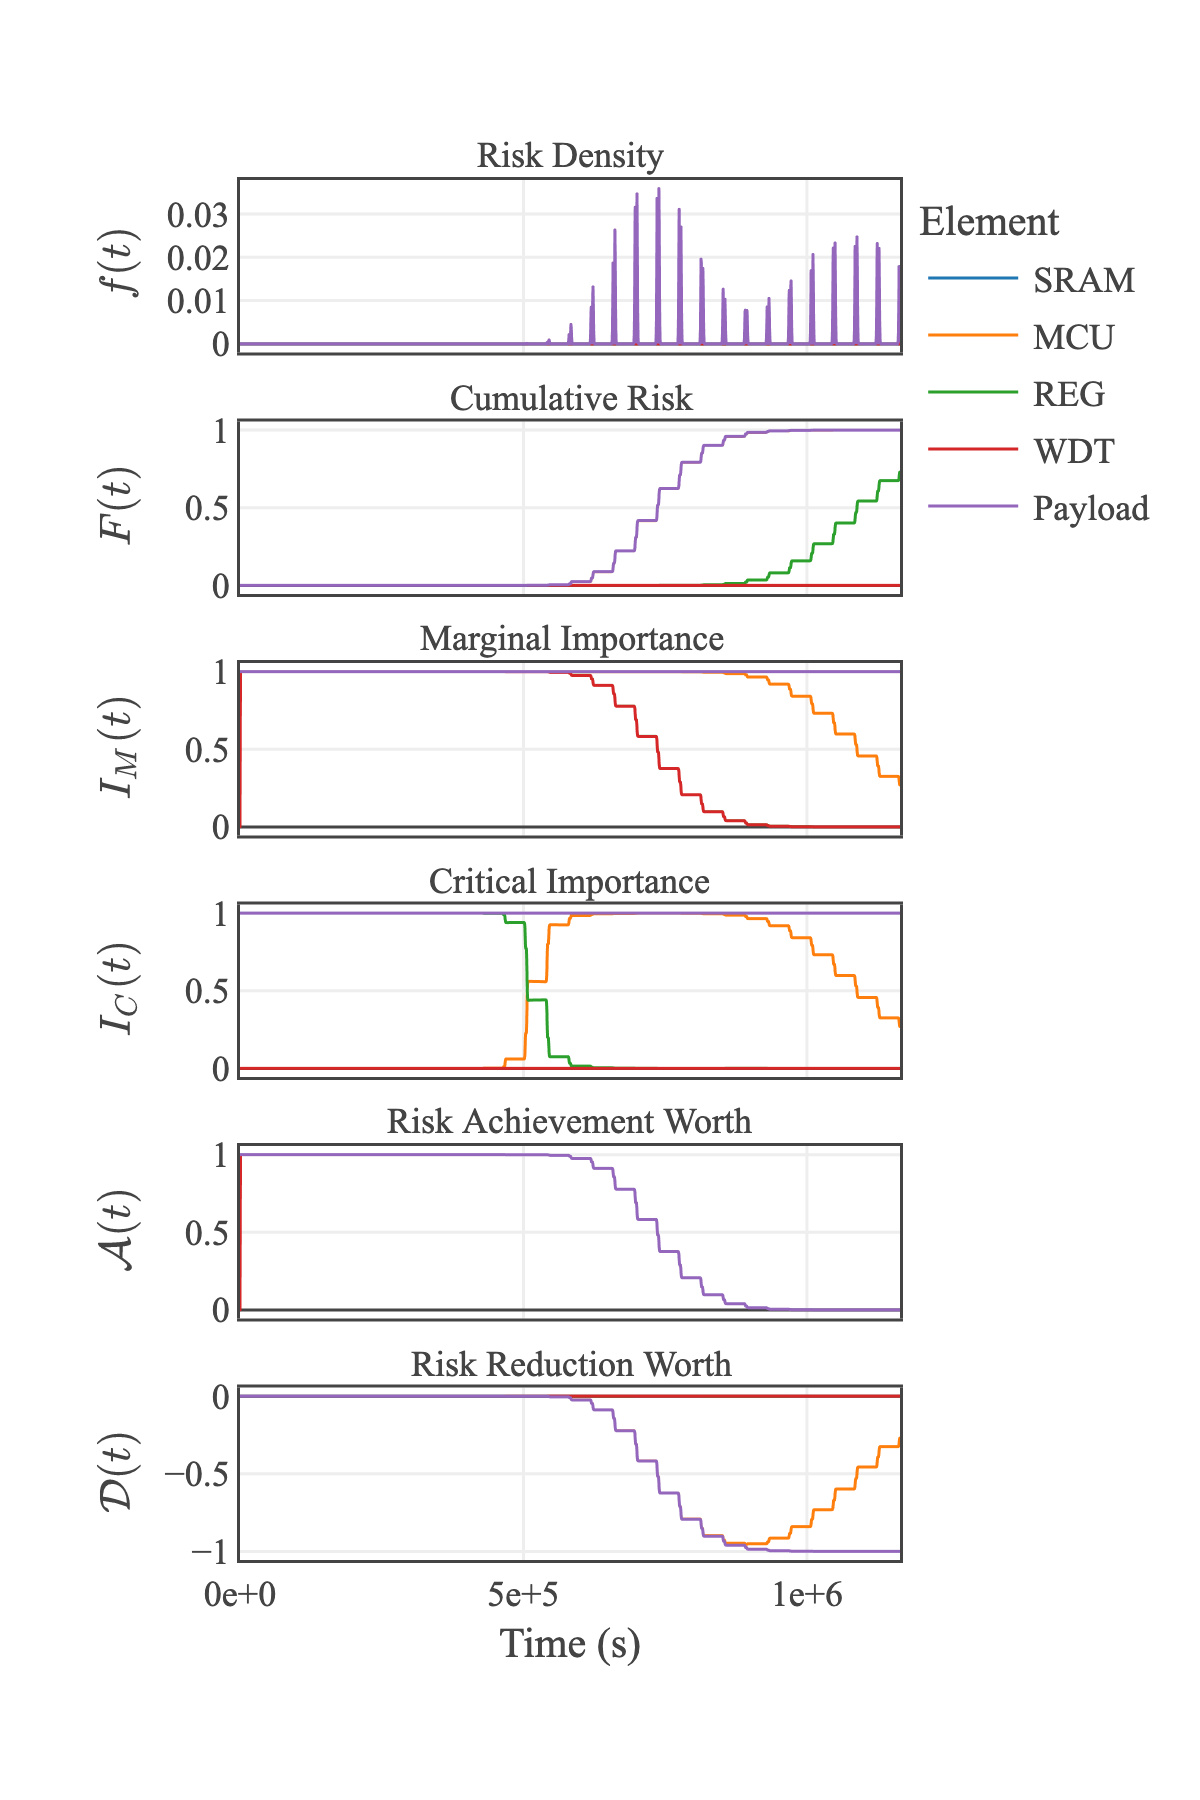

In [101]:
### plot analysis results
def get_facet(file,label,subset=None):
    df = pd.read_csv(file,index_col=0)
    subset = elements.keys() if subset is None else subset
    df = df[subset].stack().reset_index().set_index('Time (s)').rename(columns={'level_1':'Element',0:'value'})
    df['facet'] = label
    return df

pdf = get_facet(f'{project}/tables/pdf.csv','Risk Density',subset)
cdf = get_facet(f'{project}/tables/cdf.csv','Cumulative Risk',subset)
marg = get_facet(f'{project}/tables/marg.csv','Marginal Importance',subset)
crit = get_facet(f'{project}/tables/crit.csv','Critical Importance',subset)
raw = get_facet(f'{project}/tables/raw.csv','Risk Achievement Worth',subset)
rrw = get_facet(f'{project}/tables/rrw.csv','Risk Reduction Worth',subset)
df = pd.concat([pdf,cdf,marg,crit,raw,rrw])

fig = px.line(df,color='Element',facet_col='facet',facet_col_wrap=1,facet_row_spacing=0.05)
fig.update_layout(
    height = 600, width = 400,
    xaxis = {'tickformat':'.0e'},
    yaxis1 = {'title':'$\mathcal{D}(t)$','tickformat':'f'},
    yaxis2 = {'title':'$\mathcal{A}(t)$','tickformat':'f'},
    yaxis3 = {'title':'$I_C(t)$','tickformat':'f'},
    yaxis4 = {'title':'$I_M(t)$','tickformat':'f'},
    yaxis5 = {'title':'$F(t)$','tickformat':'f'},
    yaxis6 = {'title':'$f(t)$','tickformat':'f'}
)
fig.update_yaxes(showline=True,mirror=True,matches=None)
fig.update_xaxes(showline=True,mirror=True)
fig.update_traces(line={'width':1})
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[1]))
fig.write_image(f'{project}/figures/analysis.png',scale=3)
autocrop(f'{project}/figures/analysis.png')

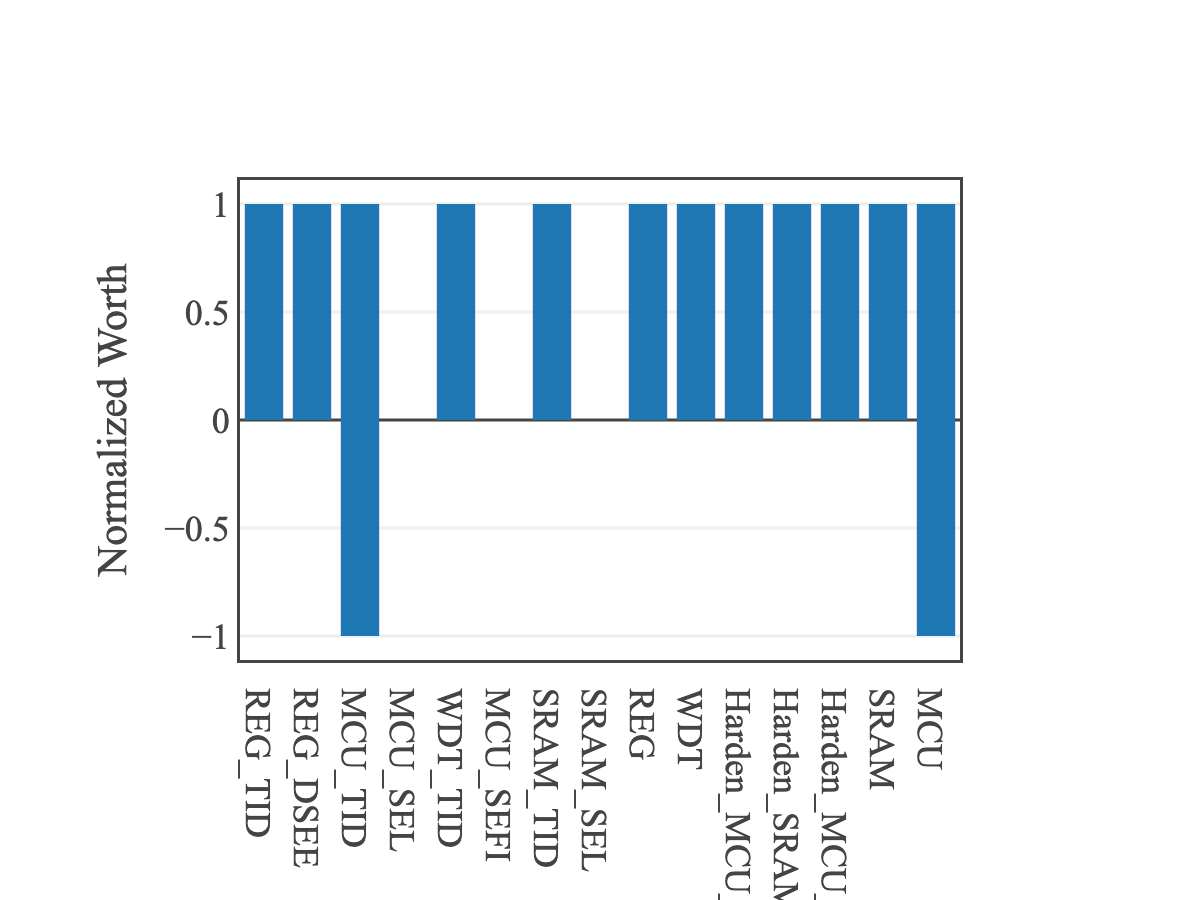

In [102]:
def integrate(df):
    df = df.dropna()
    new = {}
    for col in df.columns:
        new[col] = np.trapz(df[col],df.index)
    df = pd.Series(new)
    return df / max(df)

RAW = integrate(pd.read_csv(f'{project}/tables/raw.csv',index_col=0).drop(columns=[list(elements.keys())[-1]]))
RRW = -integrate(-pd.read_csv(f'{project}/tables/rrw.csv',index_col=0).drop(columns=[list(elements.keys())[-1]]))
fig = px.bar(RAW-RRW,base=RRW)
fig.update_layout(
    width=400, height=300,
    yaxis = {'title':'Normalized Worth','tickformat':'none'},
    xaxis = {'title':''},
    showlegend = False
).write_image(f'{project}/figures/worth.png',scale=3)
autocrop(f'{project}/figures/worth.png')

In [103]:
integrate(-pd.read_csv(f'{project}/tables/rrw.csv',index_col=0))

REG_TID            0.000206
REG_DSEE           0.000383
MCU_TID            0.802113
MCU_SEL            0.000000
WDT_TID            0.000000
MCU_SEFI           0.000000
SRAM_TID           0.000000
SRAM_SEL           0.000000
REG                0.000588
WDT                0.000000
Harden_MCU_SEFI    0.000000
Harden_SRAM_SEL    0.000000
Harden_MCU_SEL     0.000000
SRAM               0.000000
MCU                0.802113
Payload            1.000000
dtype: float64

In [104]:
def sim(system,env,cdf,N=1,root=None):
    root = system.getroot() if root is None else system.xpath(f'..//node[@name="{root}"]')[0]
    nodes = root.xpath('.//node') + [root]
    events = root.xpath('.//event')
    refs = root.xpath('.//ref')
    for ref in refs:
        if system.xpath(f'..//node[@name="{ref.get("name")}"]')[0] in nodes: continue
        else: 
            nodes = system.xpath(f'..//node[@name="{ref.get("name")}"]/..//node') + nodes
            events = system.xpath(f'..//node[@name="{ref.get("name")}"]/.//event') + events
    tfail = pd.DataFrame(index=pd.Series(range(N),name='Run'))
    elements = get_elements(system)
    max_dose = env['Total Dose (rad)'].max()
    for key in elements.keys():
        element = elements[key]
        if element['type'] == 'event':
            tfail[key] = interp1d(cdf[key].values,cdf.index.values,fill_value='extrapolate')(np.random.rand(N))
            #tfail[key] = np.random.choice(pdf.index,N,p=pdf)
        if element['type'] == 'system':
            if element['gate'] == bayes.OR: tfail[key] = tfail.apply(lambda l: l[element['inputs']].min(),axis=1)
            if element['gate'] == bayes.AND: tfail[key] = tfail.apply(lambda l: l[element['inputs']].max(),axis=1)
    sets = pd.DataFrame(columns=['Full','Minimal'],index=pd.Series(range(N),name='Run'))
    for i in sets.index:
        if tfail[key][i] > env.index[-1]: sets.loc[i] = [np.nan,np.nan]; continue
        sets['Full'][i] = list(tfail.loc[i,tfail.loc[i] <= tfail[key][i]].index)[:-1]
        set = [key]
        minimized = False
        while not minimized:
            if all([elements[s]['type'] == 'event' for s in set]): minimized = True
            for s in list(set):
                if elements[s]['type'] == 'system':
                    set.remove(s)
                    if elements[s]['gate'] == bayes.OR:
                        for child in elements[s]['inputs']:
                            if child in sets['Full'][i]: set.append(child)
                    if elements[s]['gate'] == bayes.AND:
                        if all([child in sets['Full'][i] for child in elements[s]['inputs']]):
                            set += elements[s]['inputs']
        sets['Minimal'][i] = set
    return tfail,sets

if run_sim:
    env = pd.read_csv(f'{project}/tables/env.csv',index_col=0)
    if downsample is not None:
        if len(env) > downsample:
            print('downsample ratio:',int(len(env)/downsample))
            env = env.loc[::int(len(env)/downsample)]
    cdf = pd.read_csv(f'{project}/tables/cdf.csv',index_col=0)
    system = etree.parse(f'{project}/system.xml')
    tfail,sets = sim(system,env,cdf,N=10000)
    tfail.to_csv(f'{project}/tables/mc_time.csv')
    sets.to_csv(f'{project}/tables/mc_sets.csv')
else:
    env = pd.read_csv(f'{project}/tables/env.csv',index_col=0)
    cdf = pd.read_csv(f'{project}/tables/cdf.csv',index_col=0)
    system = etree.parse(f'{project}/system.xml')
    tfail = pd.read_csv(f'{project}/tables/mc_time.csv',index_col=0)
    sets = pd.read_csv(f'{project}/tables/mc_sets.csv',index_col=0)

display(tfail)
display(sets)

,REG_TID,REG_DSEE,MCU_TID,MCU_SEL,WDT_TID,MCU_SEFI,SRAM_TID,SRAM_SEL,REG,WDT,Harden_MCU_SEFI,Harden_SRAM_SEL,Harden_MCU_SEL,SRAM,MCU,Payload
Run,,,,,,,,,,,,,,,,
0,1.336343e+06,4.679781e+09,774343.664446,557.163343,inf,759.760984,inf,514.719373,1.336343e+06,inf,inf,inf,inf,inf,774343.664446,774343.664446
1,1.089045e+06,3.216852e+09,622313.360220,1059.604770,inf,657.304307,inf,291.632483,1.089045e+06,inf,inf,inf,inf,inf,622313.360220,622313.360220
2,1.360677e+06,3.149925e+09,700084.929797,698.058621,inf,218.201275,inf,785.021703,1.360677e+06,inf,inf,inf,inf,inf,700084.929797,700084.929797
3,1.303077e+06,5.794401e+09,775172.513962,526.781412,inf,709.210540,inf,677.315692,1.303077e+06,inf,inf,inf,inf,inf,775172.513962,775172.513962
4,9.332796e+05,2.544009e+09,813270.083048,131.931646,inf,784.031731,inf,1048.374924,9.332796e+05,inf,inf,inf,inf,inf,813270.083048,813270.083048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9.730965e+05,3.932584e+09,663196.040506,758.499316,inf,931.945448,inf,517.779666,9.730965e+05,inf,inf,inf,inf,inf,663196.040506,663196.040506
9996,1.287775e+06,8.434154e+08,700830.845126,48.840473,inf,514.230062,inf,779.253437,1.287775e+06,inf,inf,inf,inf,inf,700830.845126,700830.845126
9997,1.290667e+06,6.197525e+09,658814.631981,940.218646,inf,848.830001,inf,157.219087,1.290667e+06,inf,inf,inf,inf,inf,658814.631981,658814.631981


,Full,Minimal
Run,,
0,"['MCU_TID', 'MCU_SEL', 'MCU_SEFI', 'SRAM_SEL',...",['MCU_TID']
1,"['MCU_TID', 'MCU_SEL', 'MCU_SEFI', 'SRAM_SEL',...",['MCU_TID']
2,"['MCU_TID', 'MCU_SEL', 'MCU_SEFI', 'SRAM_SEL',...",['MCU_TID']
3,"['MCU_TID', 'MCU_SEL', 'MCU_SEFI', 'SRAM_SEL',...",['MCU_TID']
4,"['MCU_TID', 'MCU_SEL', 'MCU_SEFI', 'SRAM_SEL',...",['MCU_TID']
...,...,...
9995,"['MCU_TID', 'MCU_SEL', 'MCU_SEFI', 'SRAM_SEL',...",['MCU_TID']
9996,"['MCU_TID', 'MCU_SEL', 'MCU_SEFI', 'SRAM_SEL',...",['MCU_TID']
9997,"['MCU_TID', 'MCU_SEL', 'MCU_SEFI', 'SRAM_SEL',...",['MCU_TID']


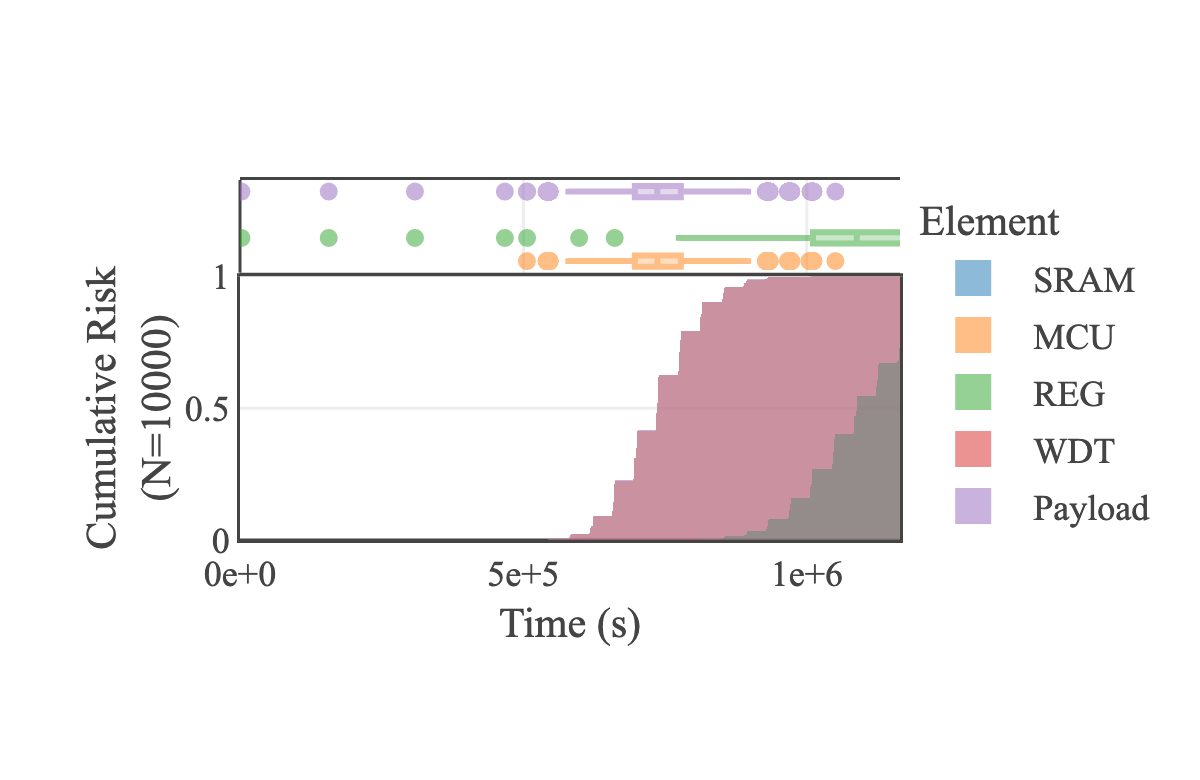

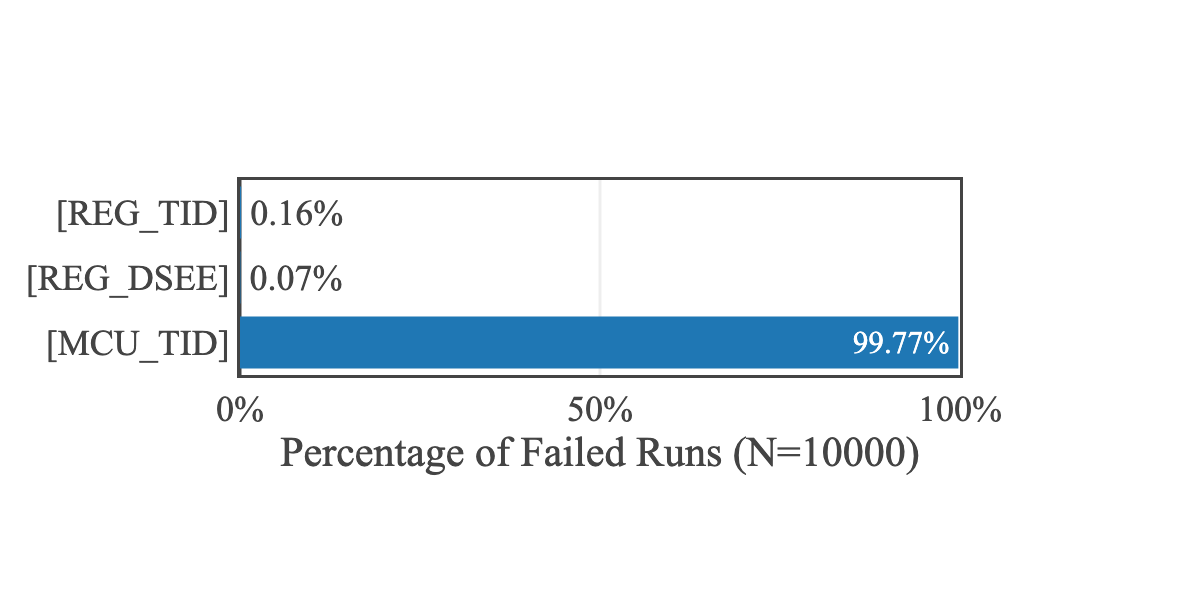

In [105]:
tmax = env.index[-1]
fig = px.histogram(tfail[subset],nbins=1000,histnorm='probability',marginal='box',cumulative=True)
fig.update_traces(opacity=0.5)
fig.update_layout(
    height = 260, width = 400,
    xaxis = {'range':[0,tmax],'title':'Time (s)','showline':True,'mirror':True,'tickformat':'.0e'},
    yaxis = {'range':[0,1],'title':f'Cumulative Risk<br>(N={len(tfail)})','showline':True,'mirror':True,'tickformat':'none'},
    legend = {'title':'Element'},
    barmode = 'overlay',
)
fig.write_image(f'{project}/figures/mc_time.png',scale=3)
display(autocrop(f'{project}/figures/mc_time.png'))

fig = px.histogram(sets['Minimal'].dropna().astype(str).str.replace("'",''),histnorm='probability',orientation='h',text_auto='~%')
fig.update_layout(
    height = 100 + 35 * len(sets['Minimal'].astype(str).unique()), width = 400,
    yaxis = {'title':'','showline':True,'mirror':True},
    xaxis = {'title':{'text':f'Percentage of Failed Runs (N={len(tfail)})','standoff':0},'tickformat':'.0%','showline':True,'mirror':True,'range':[0,1]},
    showlegend = False,
)
fig.write_image(f'{project}/figures/mc_sets.png',scale=3)
display(autocrop(f'{project}/figures/mc_sets.png'))

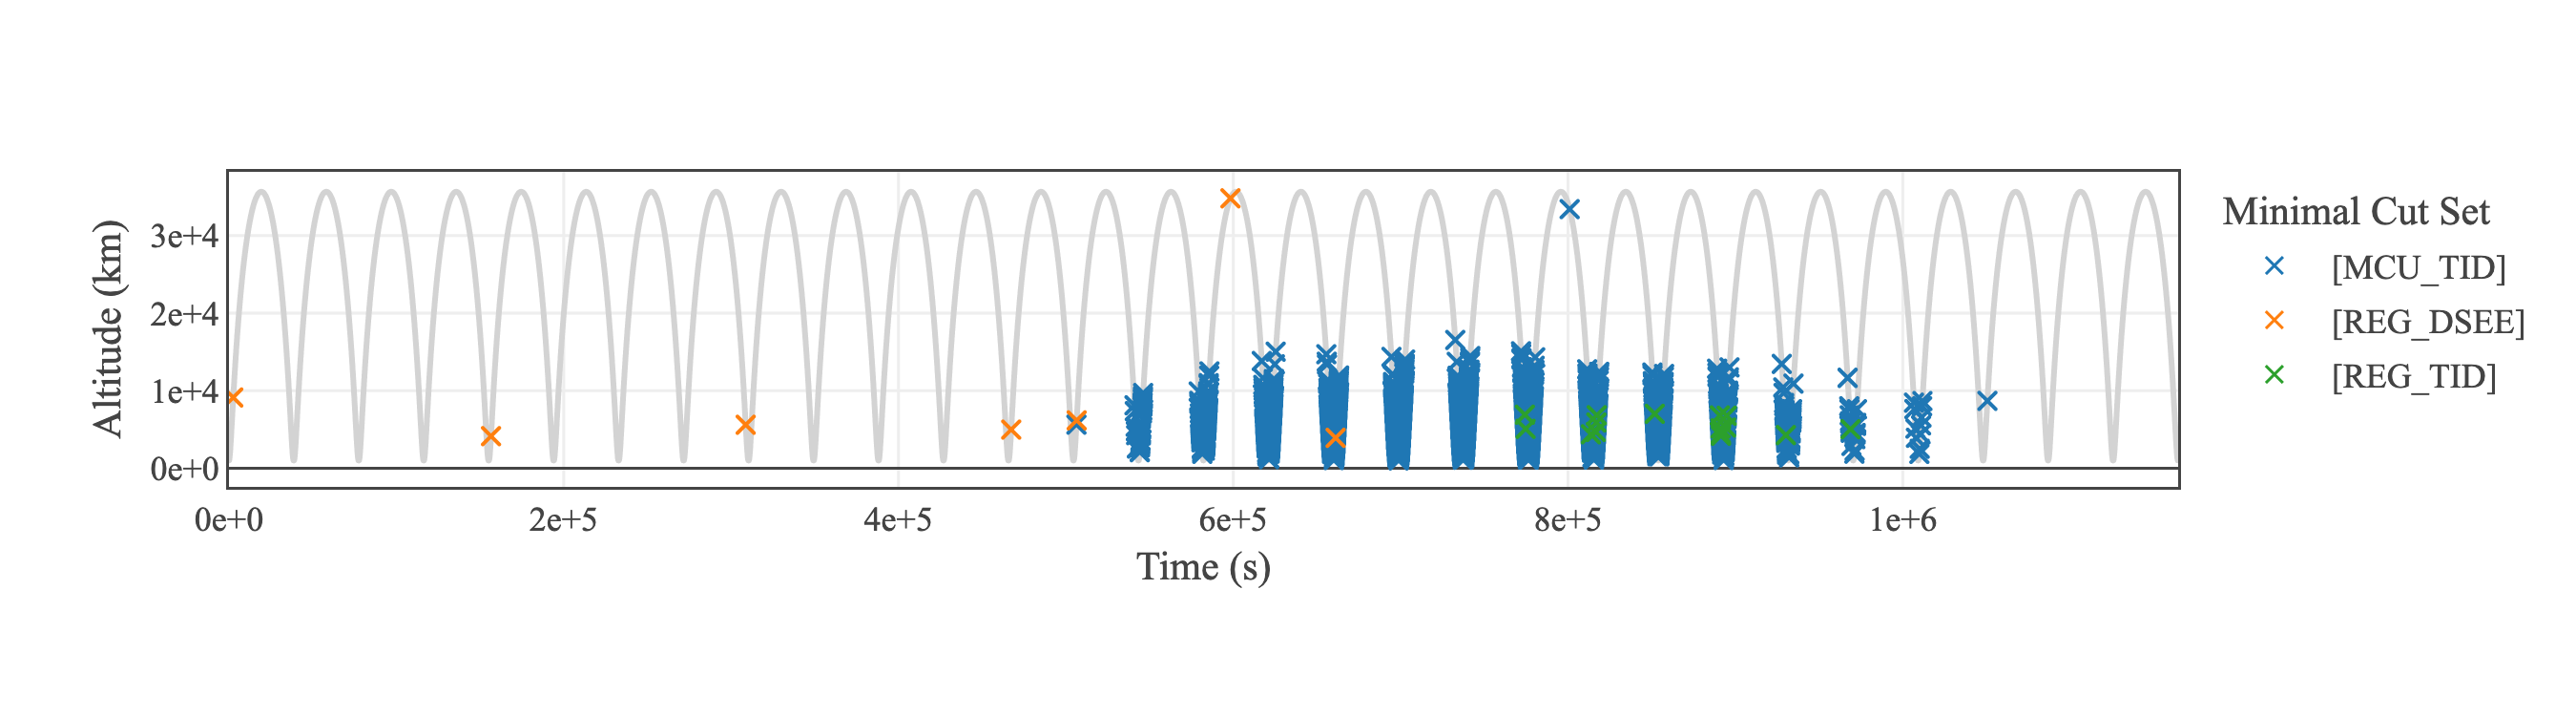

In [106]:
fig = px.line(env['Altitude (km)']).update_traces(showlegend=False,line={'color':'lightgray'})
root = list(elements.keys())[-1]
crashes = pd.DataFrame(tfail[root])
crashes['Set'] = sets['Minimal'].astype(str).str.replace("'",'')
crashes['Altitude (km)'] = interp1d(env.index,env['Altitude (km)'],fill_value='extrapolate')(crashes[root])
fig.add_traces(list(px.scatter(crashes,x=root,y='Altitude (km)',color='Set').update_traces(marker={'symbol':'x-thin-open'}).select_traces()))
fig.update_layout(
    height = 250, width = 900,
    hovermode = 'x',
    legend = {'title':'Minimal Cut Set'},
    xaxis = {'range':[0,tmax],'tickformat':'.0e'},
    yaxis = {'title':'Altitude (km)'},
    # showlegend = False
).write_image(f'{project}/figures/crashes.png',scale=3)
autocrop(f'{project}/figures/crashes.png')